In [1]:
using ViscousFlow

In [2]:
using Plots


In [3]:
my_params = Dict()
my_params["Re"] = 200

200

In [4]:
xlim = (-1.0,5.0)
ylim = (-1.0,1.0)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params)

Δs = surface_point_spacing(g,my_params)

0.027999999999999997

In [5]:
body =  NACA4(0.04,0.4,0.12,0.06)
T = RigidTransform((-0.25,0.2), 0π/180)
T(body)

NACA 4-digit airfoil with 33 points and length 1.0 and thickness 0.12
   Current position: (-0.25,0.2)
   Current angle (rad): 0.0


In [6]:
my_params["freestream average"] = 1.0
my_params["freestream frequency"]  = 0.0
my_params["freestream amplitude"] = 1.0
my_params["freestream phase"] = 0.0

0.0

In [7]:
function my_freestream(t,phys_params)
    U = phys_params["freestream average"]
    Ω = phys_params["freestream frequency"]
    Ax = phys_params["freestream amplitude"]
    ϕx = phys_params["freestream phase"]
    Vinfmag = Ax*(RigidBodyTools.Sinusoid(Ω) >> (ϕx/Ω))
    Vinf_angle = get(phys_params,"freestream angle",0.0)

    Uinf = U
    Vinf = 0
    return Uinf, Vinf
end

my_freestream (generic function with 1 method)

In [8]:
St = 0.046
f = my_params["freestream average"]*St/0.12

Ω = 2π*f
Δα = 20π/180 # amplitude of pitching
ϕα = 0.0

oscil1 = RigidBodyTools.RotationalOscillation(Ω,Δα,ϕα)
motion = RigidBodyMotion(oscil1)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.84
  α̈ = 0.0
  Oscillatory kinematics with
     Steady velocity U = (0.0,0.0)
     Ref angle α₀ = 0.0
     Mean rotation rate α̇₀ = 0.0
     Pitch axis (rel. to centroid) a = (0.0,0.0)
     Frequency Ω = 2.408554367752175
     x amplitude Ax, phase lag ϕx = (0.0, 0.0)
     y amplitude Ay, phase lag ϕy = (0.0, 0.0)
     α amplitude Δα, phase lag ϕα = (0.3490658503988659, 0.0)


In [9]:
forcing_dict = Dict("freestream" => my_freestream)


Dict{String, typeof(my_freestream)} with 1 entry:
  "freestream" => my_freestream

In [10]:
sys = viscousflow_system(g,body,phys_params=my_params,motions = motion, forcing=forcing_dict);


In [11]:
u0 = init_sol(sys)
tspan = (0.0,5.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 308, ny = 104) cell grid of type Float64 data
  Number of Dual nodes: (nx = 308, ny = 104), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [12]:
@time step!(integrator,4)

102.190750 seconds (19.09 M allocations: 44.415 GiB, 2.37% gc time, 3.09% compilation time)


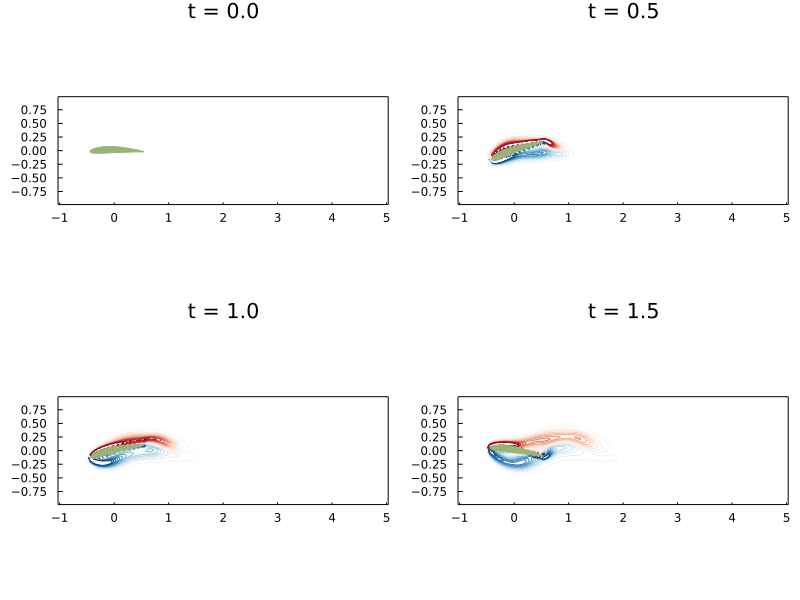

In [13]:
sol = integrator.sol
plt = plot(layout = (2,2), size = (800, 600), legend=:false)
tsnap = 0:0.5:1.5
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,layers=false,title="t = $(round(t,digits=2))",clim=(-10,10),levels=range(-10,10,length=30),color = :RdBu)
    plot!(plt[i],surfaces(sol,sys,t))
end
plt

┌ Info: Saved animation to 
│   fn = D:\CFD\Kuanyshova_proj9\code_Kuanyshvoa\tmp.gif
└ @ Plots C:\Users\aikos\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("D:\\CFD\\Kuanyshova_proj9\\code_Kuanyshvoa\\tmp.gif")
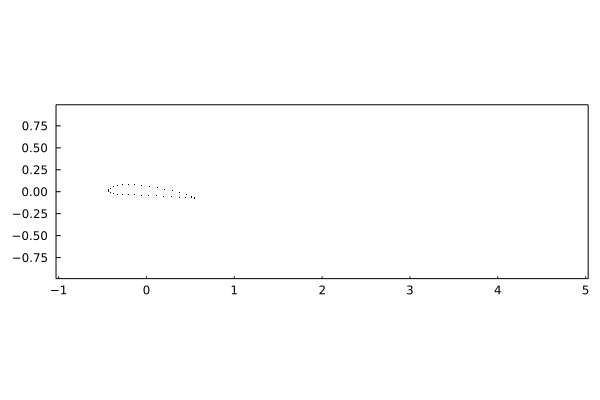

In [14]:
@gif for t in sol.t
  plot(vorticity(sol,sys,t),sys,clim=(-10,10),levels=range(-10,10,length=30), c = :RdBu)
end every 2

In [ ]:
#For 1 simulation
Δt = 0.012
N = 210
M = 5
k = 0
Data = Array{Float64, 2}(undef, N , 2016)
Bigdata = Array{Float64, 2}(undef, N , 2016*M) 
for i in 1:M
    u0 = init_sol(sys)
    tspan = (0.0+k,5.0)
    integrator = init(u0,tspan,sys)
    for j in 1:N
        step!(integrator,Δt)
        a = transpose(vec(vorticity(integrator)[100:195,15:35]))
        Data[j,:] = a
    end
    k = k + 0.5 
    Bigdata[:,((i-1)*2016).+(1:2016)] = Data
end

In [ ]:
npzwrite("St9.npz",Bigdata)